# Probablistic Programming - Chapter 2

These are notes based on Chapter 2 of [Cam Davidson Pilon's Probabilistic Programming for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).  Some notes from [Getting Started with PyMC3](https://docs.pymc.io/notebooks/getting_started.html).

* From Getting Started:
  * PyMC3 features next-generation MCMC sampling algorithms such as NUTS, a self-tuning variant of Hamiltonian Monte Carlo.
  * These allow for much faster convergence by using gradient information from likelihood.
  * NUTS also self-tunes, reducing the necessity for users to understand the algorithm in detail.
  * Backend is Theano.
* PyMC3 uses context managers to populate model variables.  Any variables placed inside a model's context manager (such as `x` below) are added to the model

```Python
basic_model = pymc3.Model()

with basic_model:
    x = pymc3.Normal('alpha', mu=0, sigma=10)
    ...
```

* (Recall that using `with ... as x` adds `x` to the namespace the `with` block is in.  If `x` is a file handle from `open`, `x` is instantiated, then context manager actions are run (for the file handle, opening the file at the start and closing at the end of the block).
* **Defining** variables must be done inside `with` blocks, since they're registered with the model as part of the model's `__exit__`.  **Accessing** model values afterward isn't.
* 

In [4]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)
    
    # Manually specifying initial value.
    test1 = pm.Exponential("test1", 1., testval=0.5)

In [5]:
# Can request a test value from parameter.  
parameter.tag.test_value

array(0.69314718)

In [6]:
test1.tag.test_value

array(0.5)

* PyMC3 will notify the user about any pre-transformations it performs to modify the space the variable is sampled from (these are done to speed up convergence).
* PyMC3 is concerned with two types of variables:
  * Stochastic variables, like `pm.Poisson`.
  * Deterministic variables, which are in themselves not random, but may depend on stochastic variables.

In [24]:
import pymc3 as pm

def subtract(x, y):
    return x - y

with pm.Model() as dummy:
    # Stochastic variable, where lower, upper bounds are specified.
    # shape generates a number of IID variables.
    betas = pm.Uniform("betas", 0, 10, shape=5)

    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    # Implicitly creates a deterministic variable
    lambda_deterministic = lambda_1 + lambda_2

    # Explicitly create a deterministic variable.
    lambda_diff = pm.Deterministic("Delta", subtract(lambda_2, lambda_1))

* For more sophisticated operations, Theano operations are used - eg. `theano.tensor.stack` rather than `numpy.stack`.
* Priors for model parameters are created by specifying their distributions, as above.

/home/czhu/pipenv/bditto/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


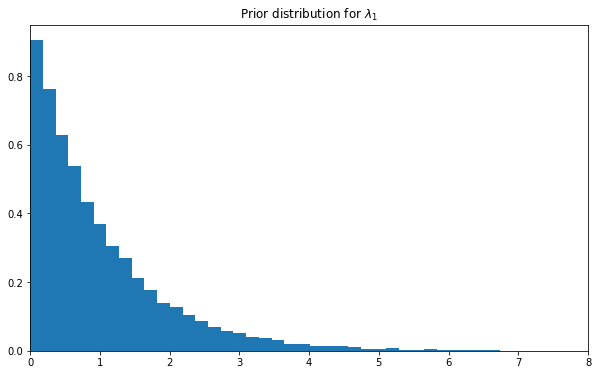

In [17]:
import matplotlib.pyplot as plt

samples = lambda_1.random(size=20000)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(samples, bins=70, normed=True, histtype="stepfilled")
ax.set_title("Prior distribution for $\lambda_1$")
ax.set_xlim(0, 8);

* To create an **observed stochastic** variable - to calculate likelihoods with - use the `observed` keyword.

In [27]:
import numpy as np

with dummy:
    obs = pm.Poisson("obs", lambda_deterministic, observed=np.random.randint(10, size=1000))